In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from glob import glob
from typing import List
from skimage import morphology
from skimage import measure
from skimage.morphology import erosion, opening, disk, label
from skimage.morphology import rectangle
from scipy.ndimage import gaussian_filter

In [2]:
paths: List[Path] = [Path(i) for i in sorted(glob("dataset/*.mp4"))]
paths

[PosixPath('dataset/jour_1.mp4'),
 PosixPath('dataset/jour_2.mp4'),
 PosixPath('dataset/jour_3.mp4'),
 PosixPath('dataset/jour_6.mp4')]

## Utils

In [3]:
def show_25_next_frames(frames: np.ndarray, index: int) -> None:
    plt.figure(figsize=np.array((16, 9))*2)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.title(f"frame : {i+index}")
        plt.imshow(frames[i+index], cmap="gray")
    plt.show()

In [4]:
def histogram(frame: np.ndarray) -> np.ndarray:
    hist = np.zeros(256, dtype=int)

    for val in frame.flatten():
        hist[val.astype(int)] += 1

    return hist


def cum_hist(hist: np.ndarray, min_val: int, max_val: int) -> np.ndarray:
    for i in range(min_val, max_val + 1):
        hist[i] += hist[i - 1]

    return hist

def equalize_hist(frame : np.ndarray) -> np.ndarray :
    hist = cum_hist(histogram(frame), 1, 255)

    length = frame.shape[0] * frame.shape[1]
    image_cpy = frame.reshape(length).astype(float)
    for i in range(length) :
        image_cpy[i] = hist[int(image_cpy[i])] / length

    frame = image_cpy.reshape(frame.shape)
    return frame

In [5]:
def show_hist(frame: np.ndarray, ylog: bool = False) -> None:
    hist = histogram(frame)

    plt.figure(figsize=(16, 9))
    plt.xlabel("Valeur en niveau de gris")
    plt.xticks(np.arange(range[0], range[-1], 10))
    if ylog:
        plt.yscale('log')

    plt.ylabel("Nombre de pixels")
    plt.plot(hist[1][:-1], hist[0], color='black')
    plt.show()

In [6]:
def FFT_(x):
    l = len(x)

    if l == 1:
        return x

    X_even = FFT_(x[::2])
    X_odd = FFT_(x[1::2])
    factor = np.exp(-2j * np.pi * np.arange(l) / l)

    X = np.concatenate([X_even + factor[:int(l/2)] * X_odd,
                       X_even + factor[int(l/2):] * X_odd])
    return X


def fft(x):
    return FFT_(x)


def compute_frequency(array: np.ndarray, fft_func) -> float:
    fft_result = fft_func(array)
    dominant_frequency_index = np.argmax(np.abs(fft_result[1:]))
    sampling_rate = 1 / 30
    duration = len(array) * sampling_rate
    dominant_frequency = dominant_frequency_index / duration
    return dominant_frequency * 60

In [7]:
def otsu_threshold(frame : np.ndarray) -> int:
    hist = histogram(frame)

    prob = hist / float(frame.size)
    cum_prob = np.cumsum(prob)
    cum_mean = np.cumsum(prob * np.arange(256))

    max_variance = 0
    threshold = 0

    for i in range(256):
        prob_class1 = cum_prob[i]
        prob_class2 = 1.0 - prob_class1

        if prob_class1 == 0 or prob_class2 == 0:
            continue

        mean_class1 = cum_mean[i] / prob_class1
        mean_class2 = (cum_mean[255] - cum_mean[i]) / prob_class2

        variance = prob_class1 * prob_class2 * (mean_class1 - mean_class2) ** 2

        if variance > max_variance:
            max_variance = variance
            threshold = i

    return threshold

def get_mask(frame : np.ndarray) -> np.ndarray:
    current = (equalize_hist(frame.copy()) * 255).astype(np.uint8)
    current = erosion(current, disk(1))

    otsu = otsu_threshold(current)
    current = current < otsu

    rect = rectangle(2,20)
    current = opening(current, rect)
    current = opening(current, rect.T)
    current = opening(current, np.eye(30)[::-1] + np.eye(30, k=1)[::-1])
    current = opening(current, np.eye(30) +  np.eye(30, k=1))
    
    current, num = label(current, return_num=True)

    for j in range(num):
        if current[0,0] == j or current[-1,0] == j or current[0,-1] == j or current[-1,-1] == j:
            current[current == j] = 0

    regions_size = np.mean([region.area for region in measure.regionprops(label(current))])
    current = morphology.remove_small_objects(current , min_size=regions_size)
    
    return current > 0

def get_boundaries(mask : np.ndarray)-> np.ndarray:
    minx = 0
    maxx = mask.shape[0] - 1

    miny = 0
    maxy = mask.shape[-1] - 1

    while not np.any(mask[minx, :]):
        minx += 1
    
    while not np.any(mask[maxx, :]):
        maxx -= 1

    while not np.any(mask[:, miny]):
        miny += 1

    while not np.any(mask[:, maxy]):
        maxy -= 1

    return [minx,maxx+1,miny, maxy+1]

In [8]:
def load_video_as_frame(path : str) -> np.ndarray:
    video = cv2.VideoCapture(filename=path)
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)[..., 2])

    frames = np.array(frames)
    video.release()
    return frames

## Our solution

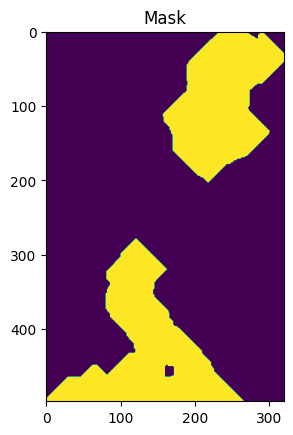

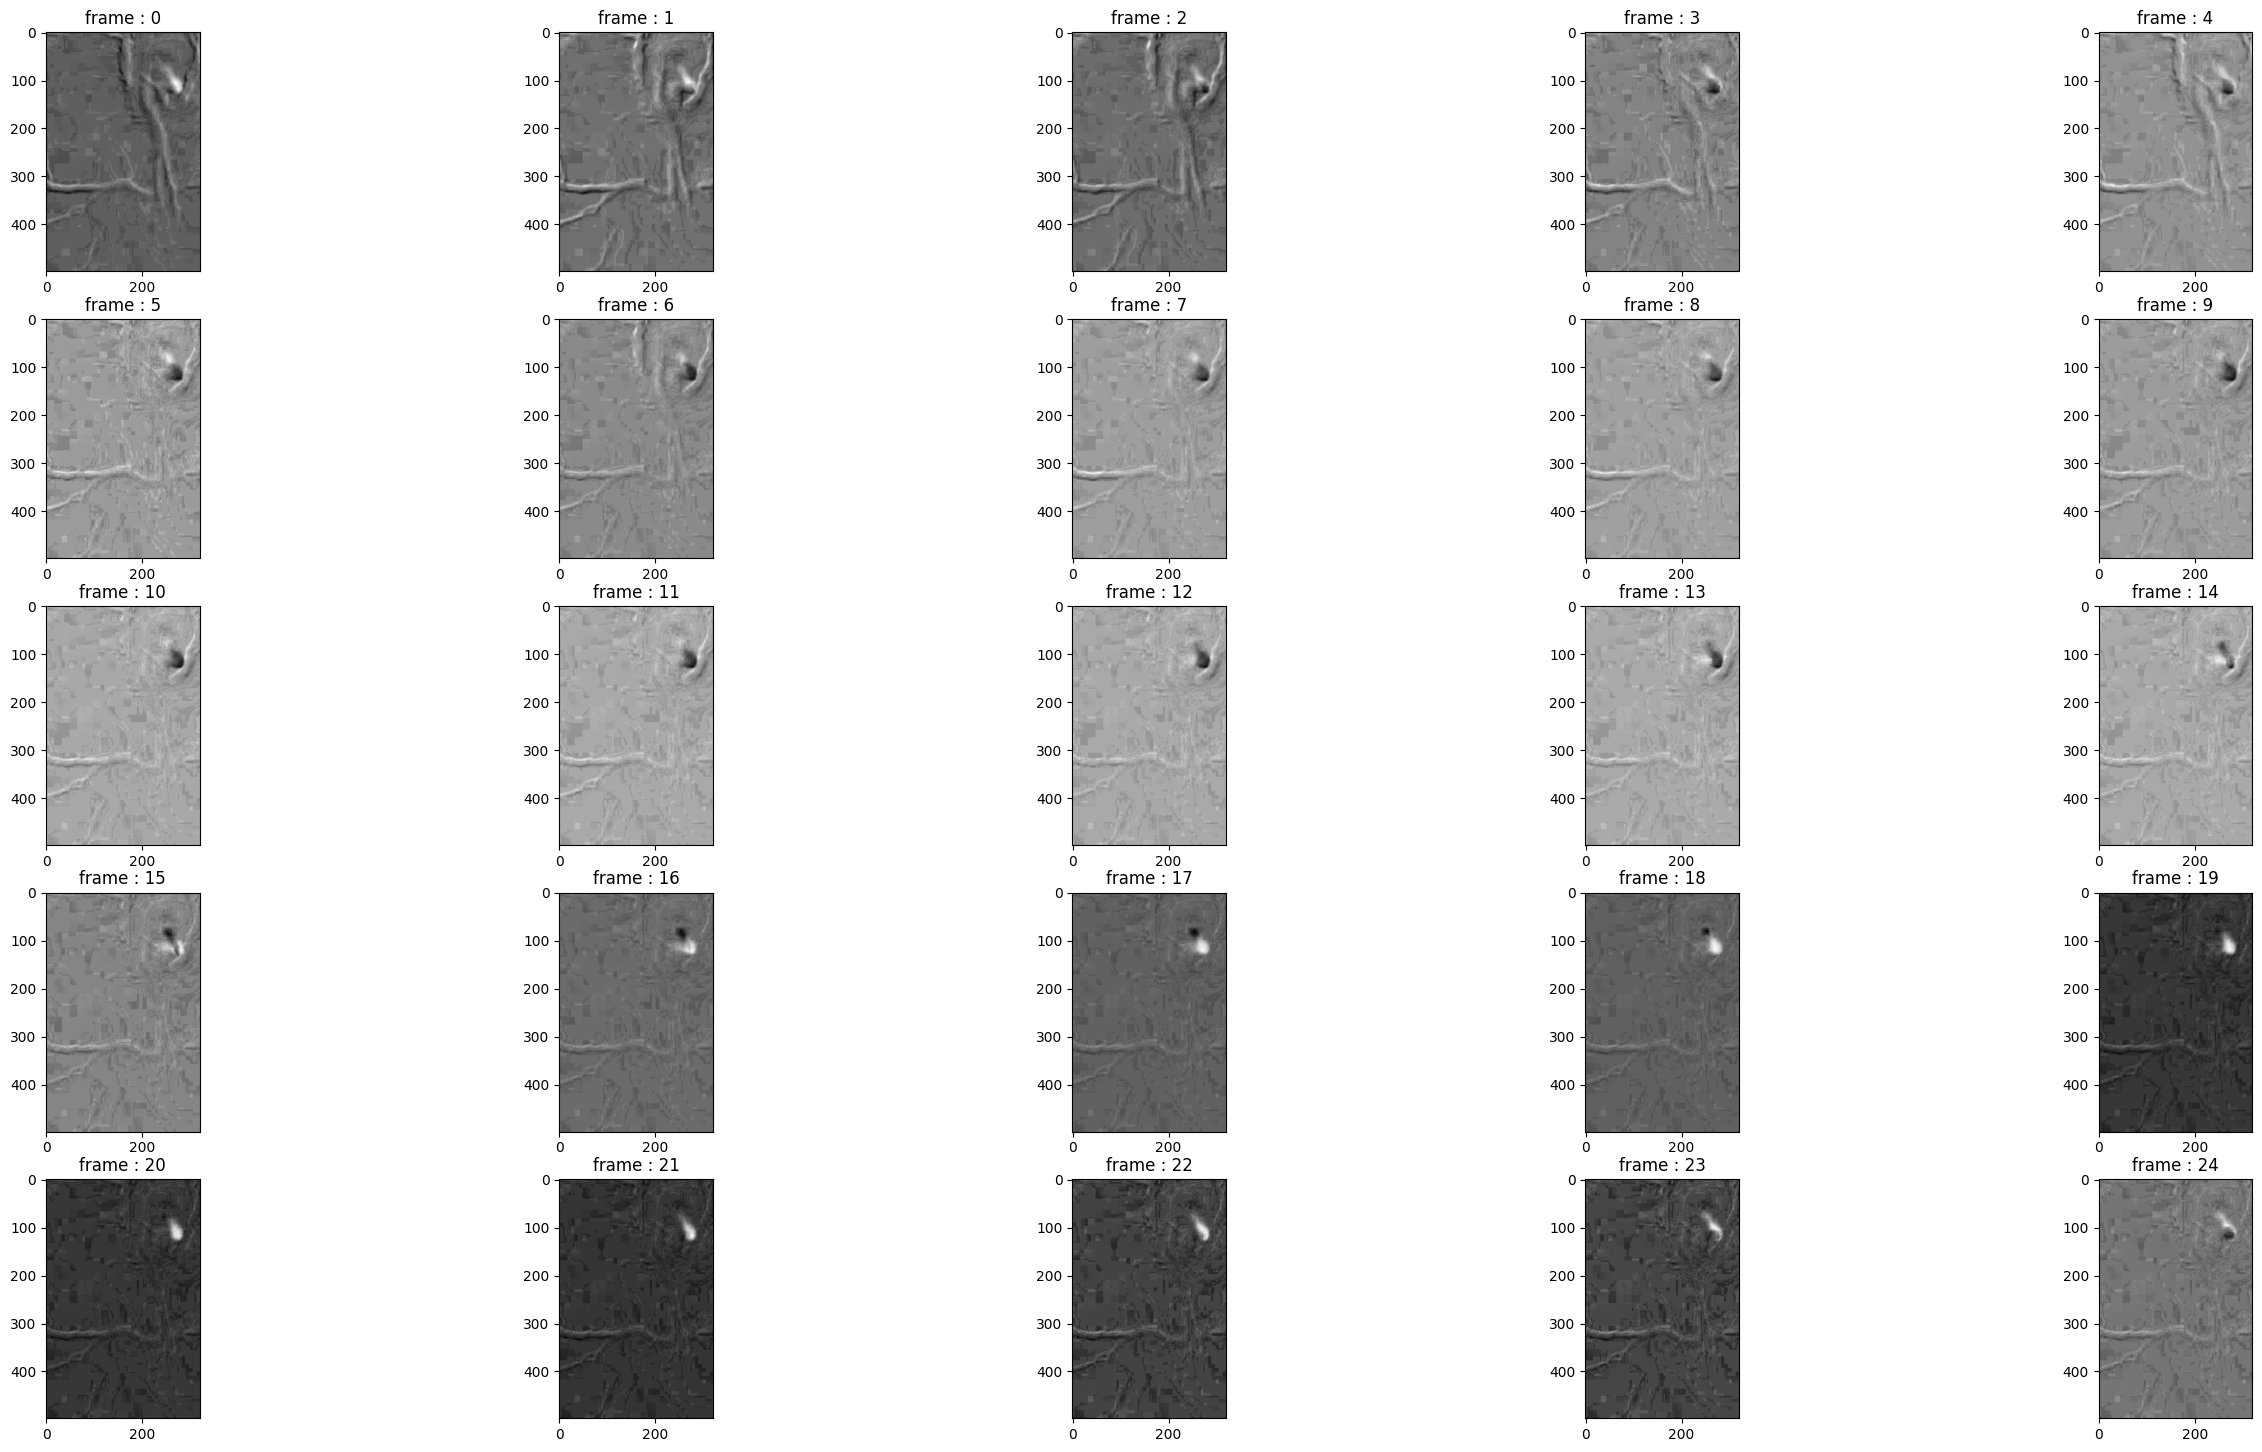

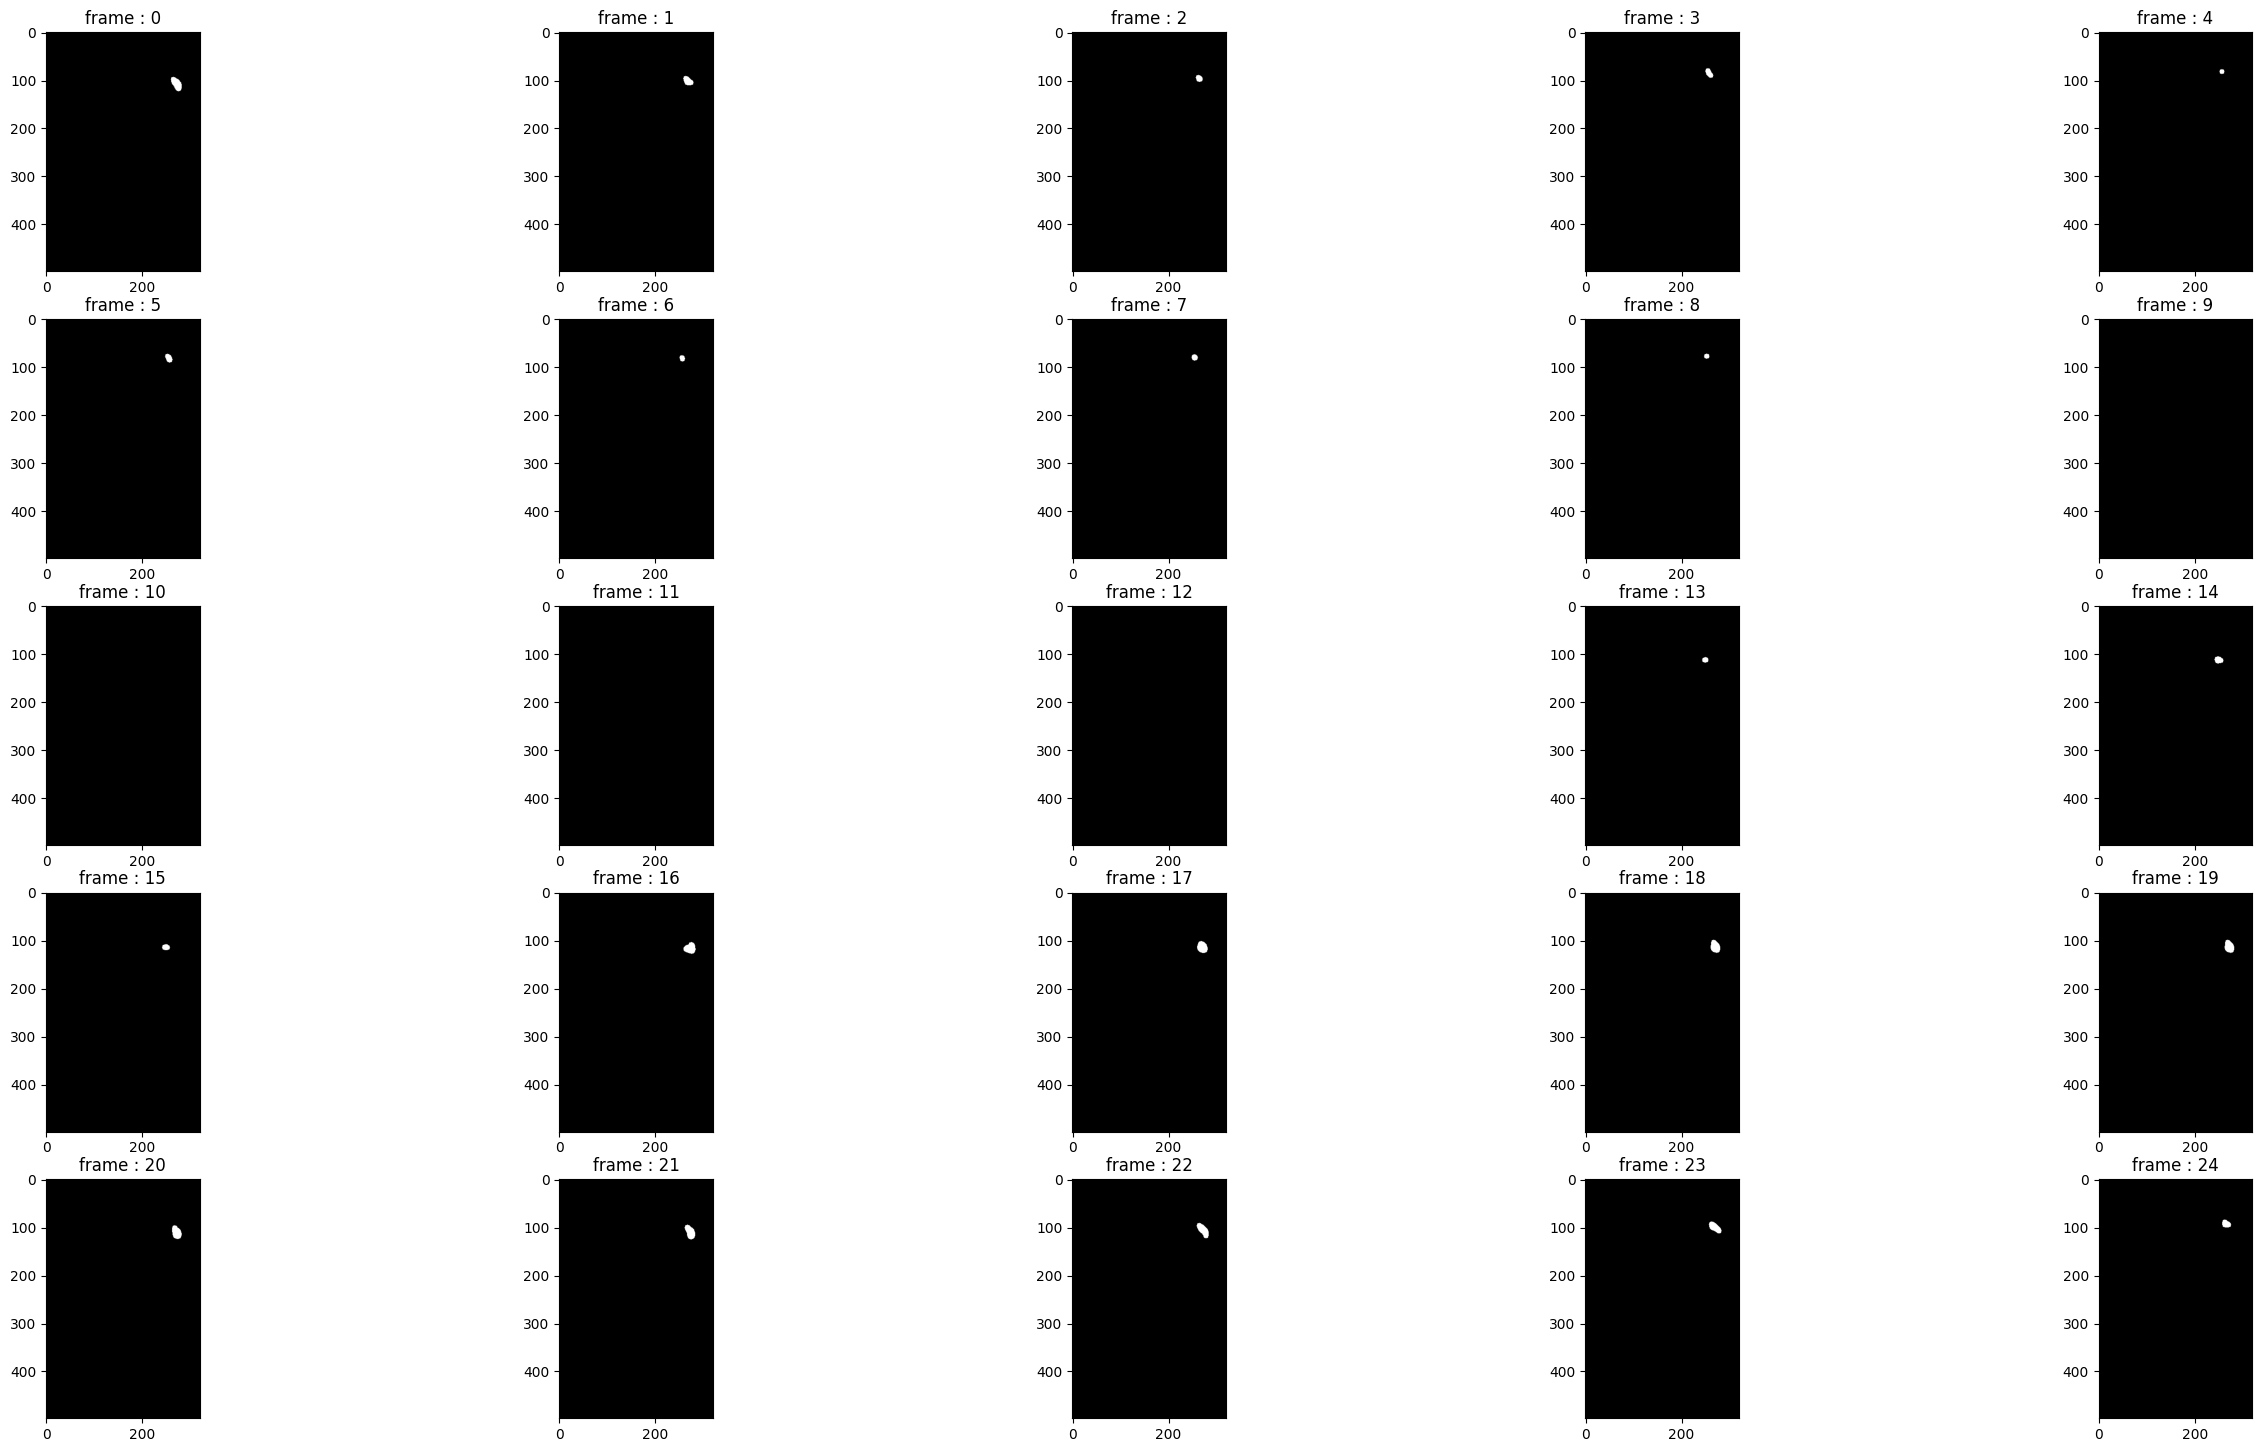

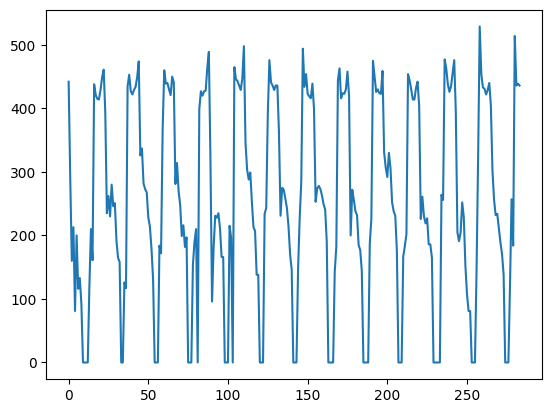

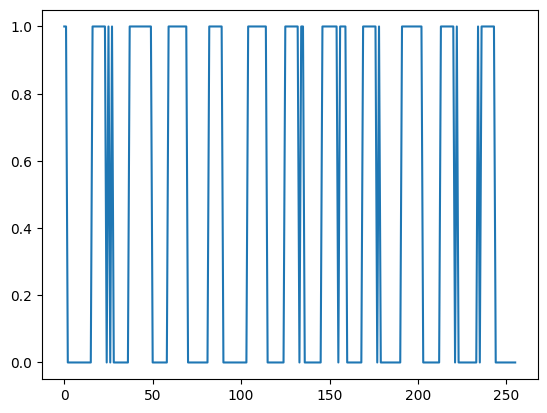

frequency for video dataset/jour_1.mp4 with numpy's fft : 77.34375
frequency for video dataset/jour_1.mp4 with our fft : 77.34375


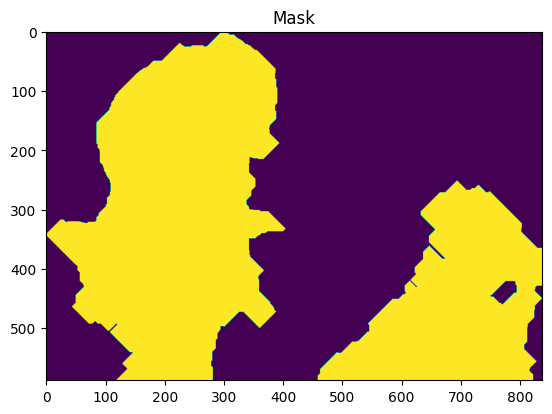

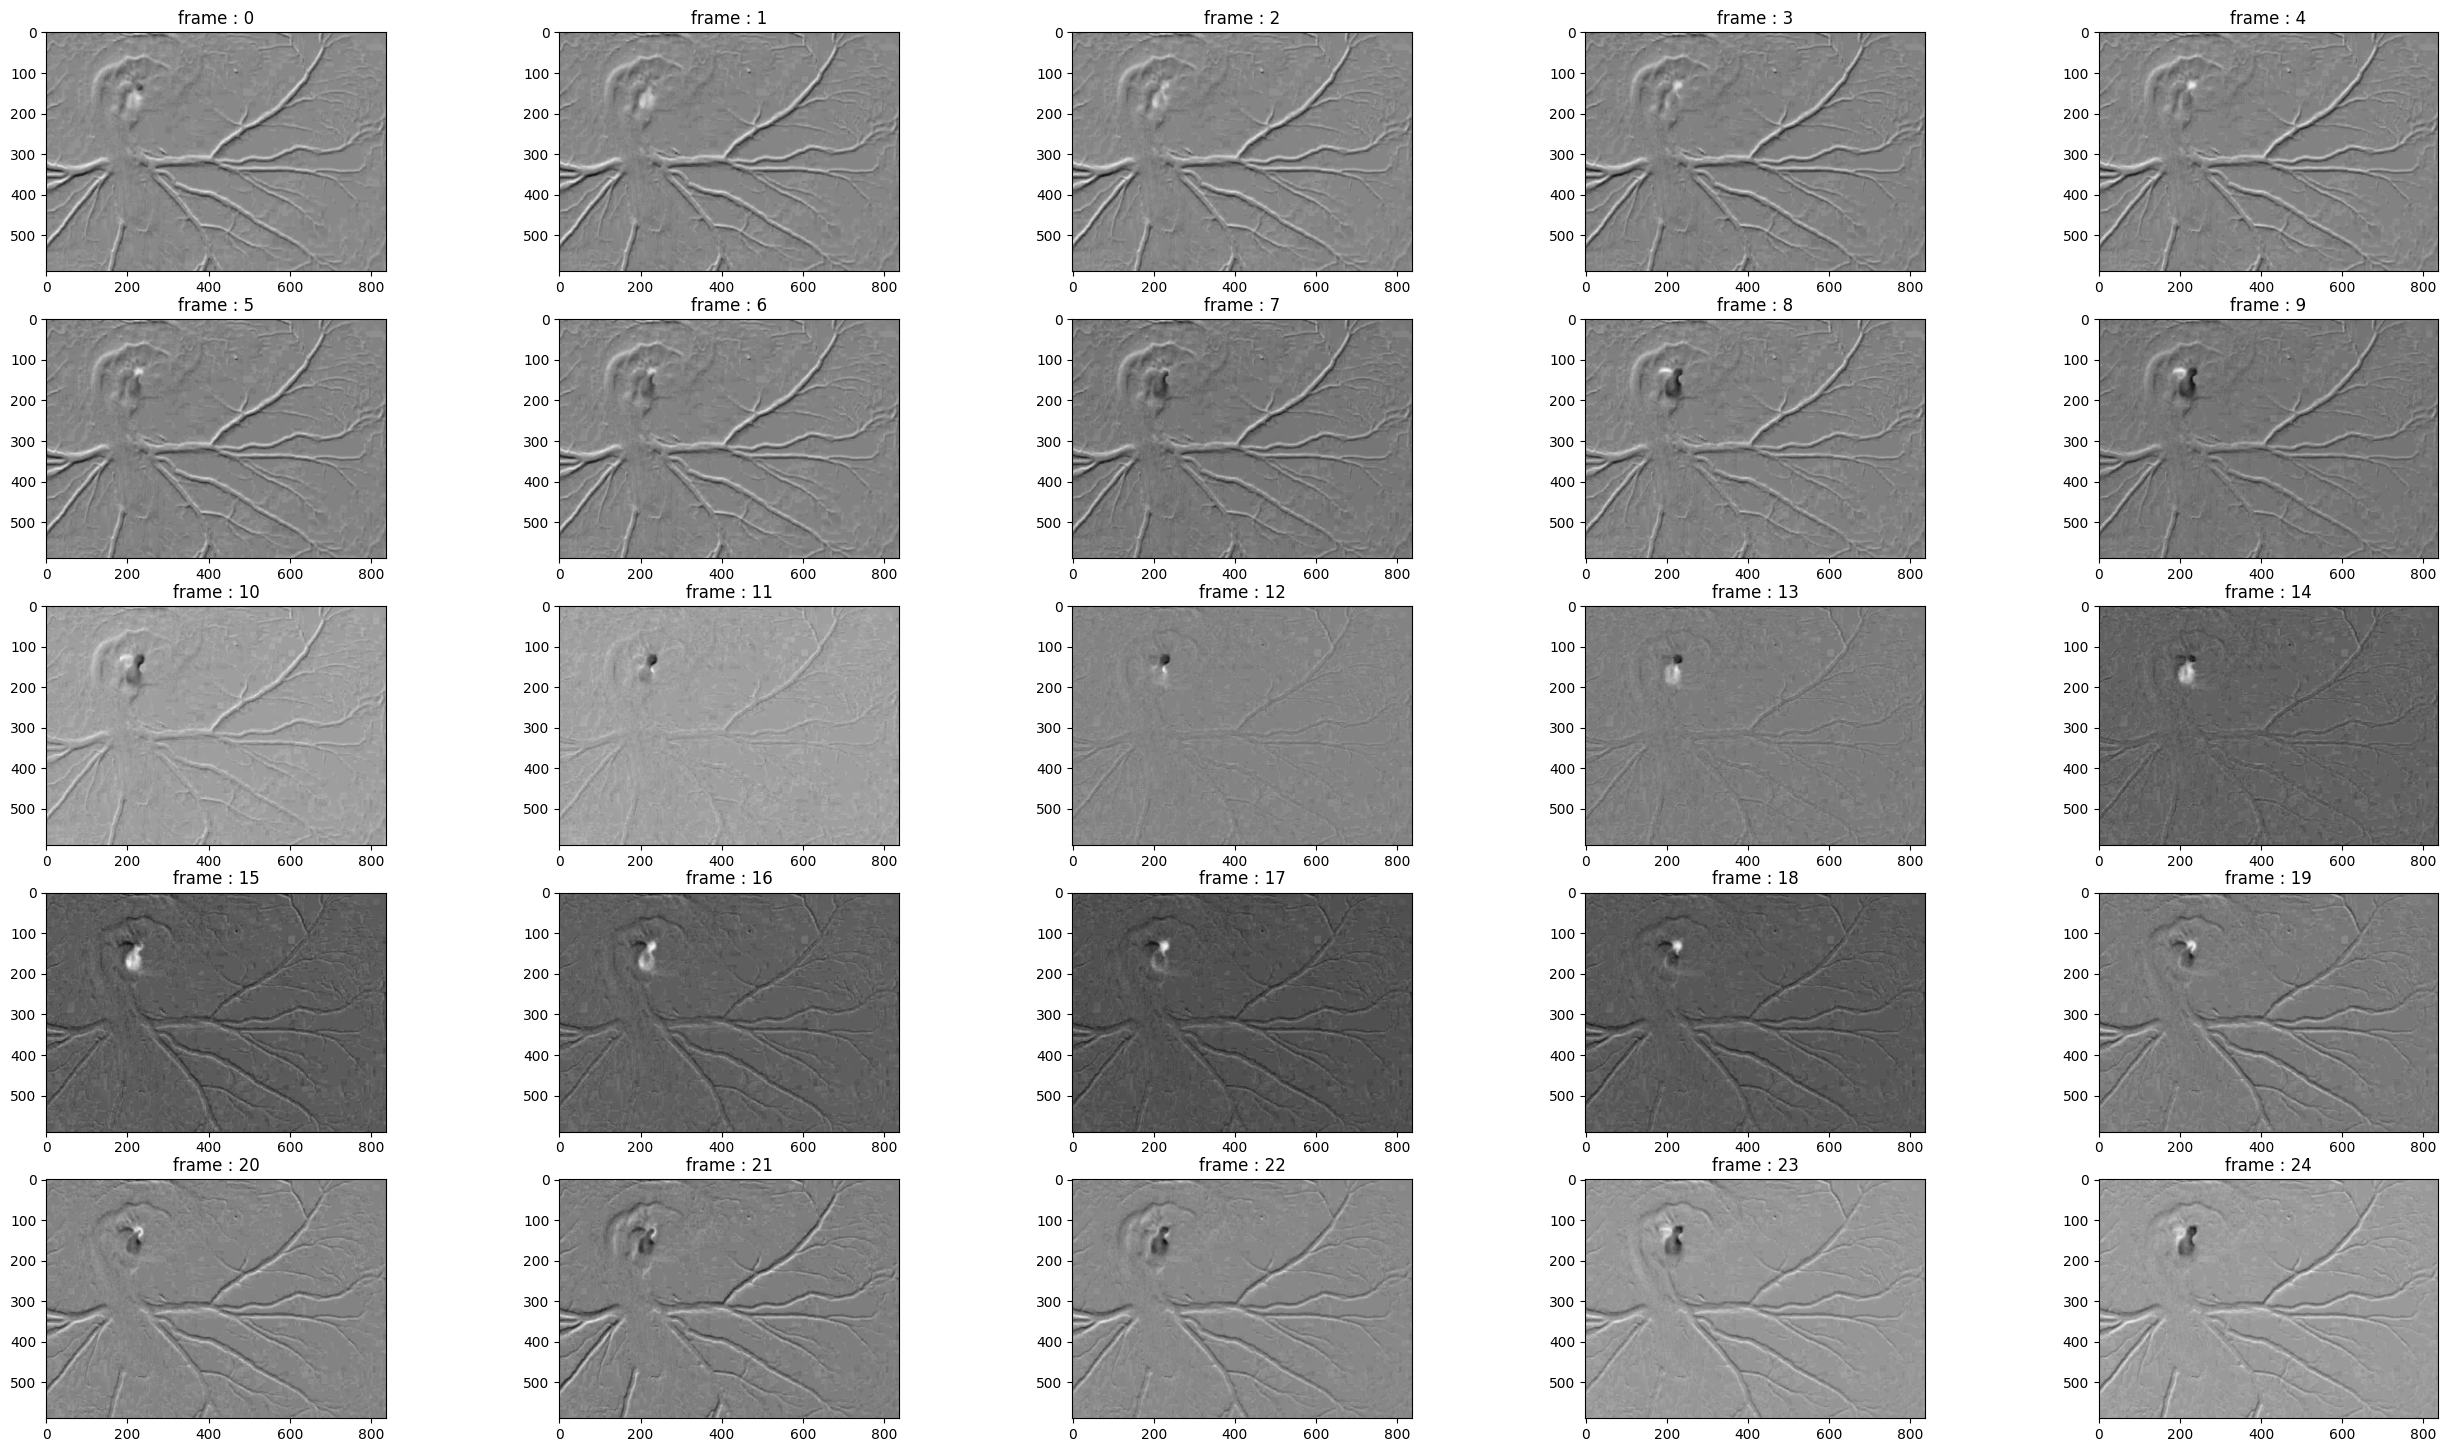

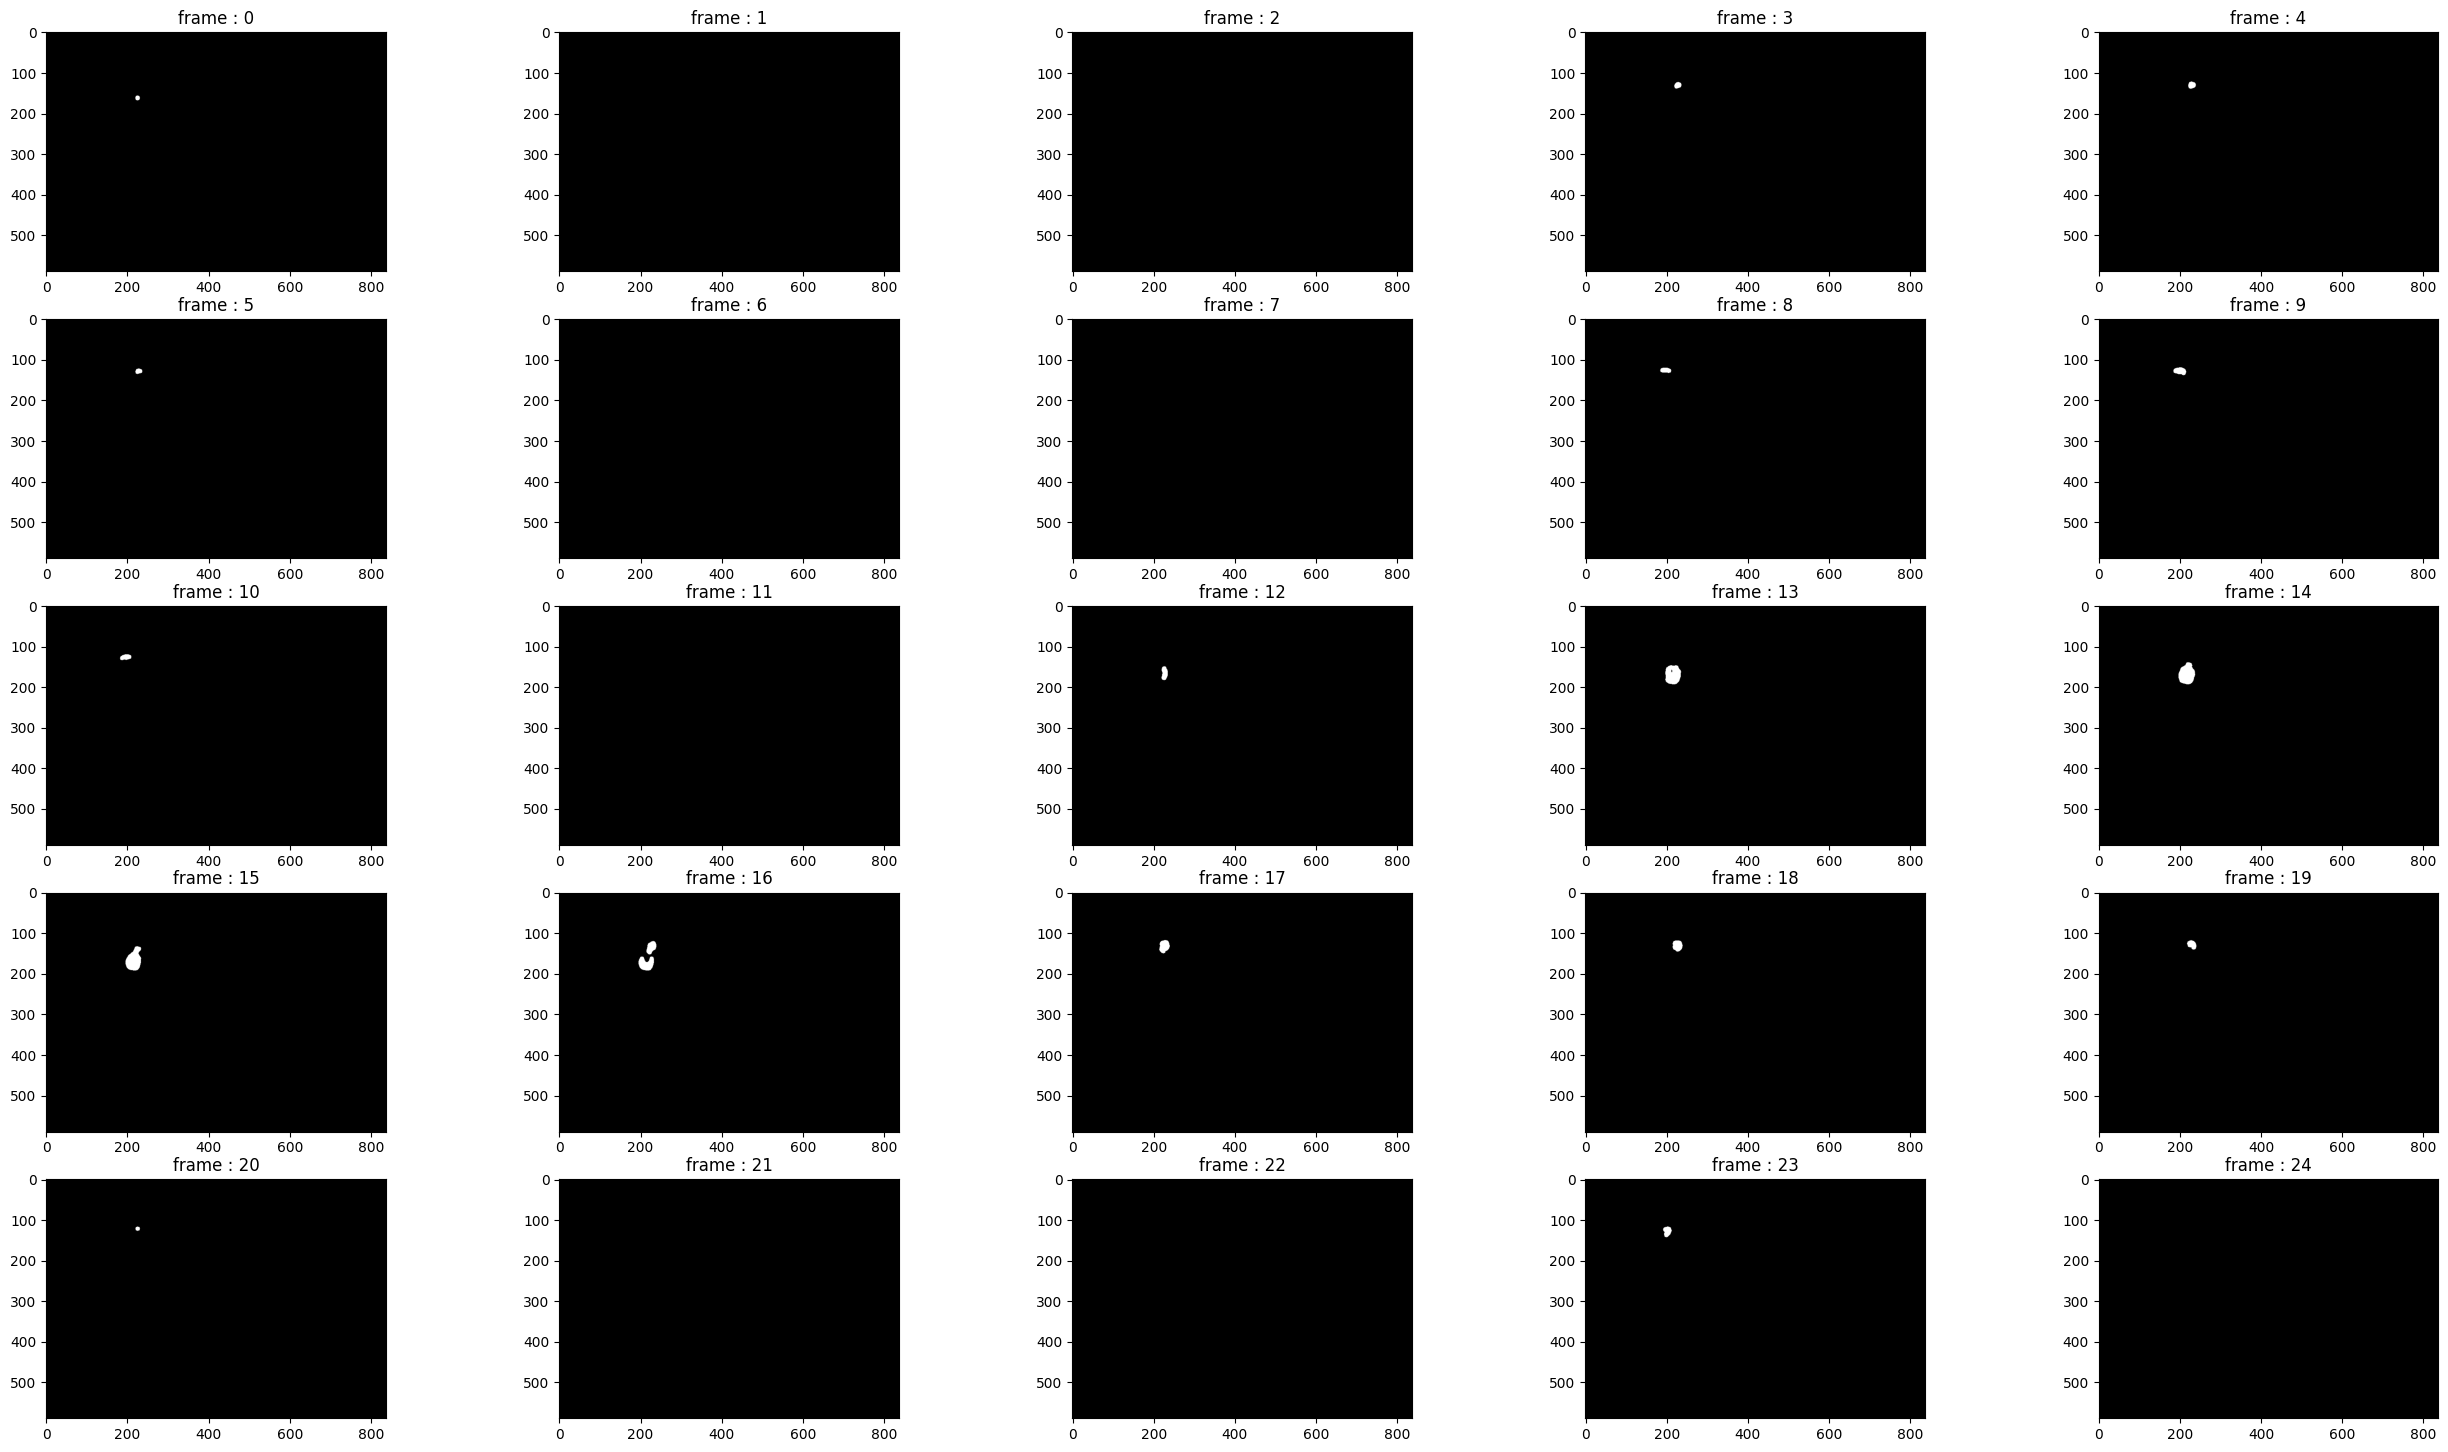

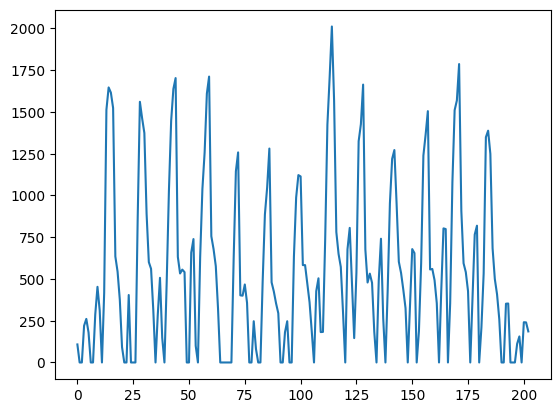

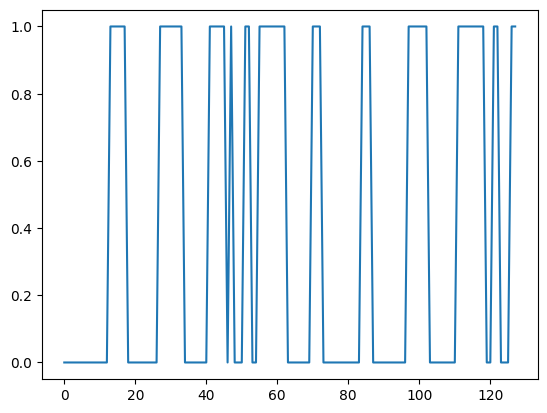

frequency for video dataset/jour_2.mp4 with numpy's fft : 112.5
frequency for video dataset/jour_2.mp4 with our fft : 112.5


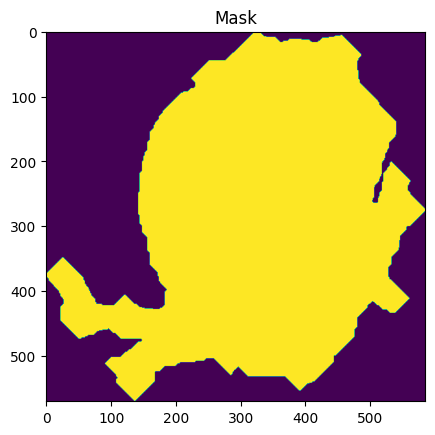

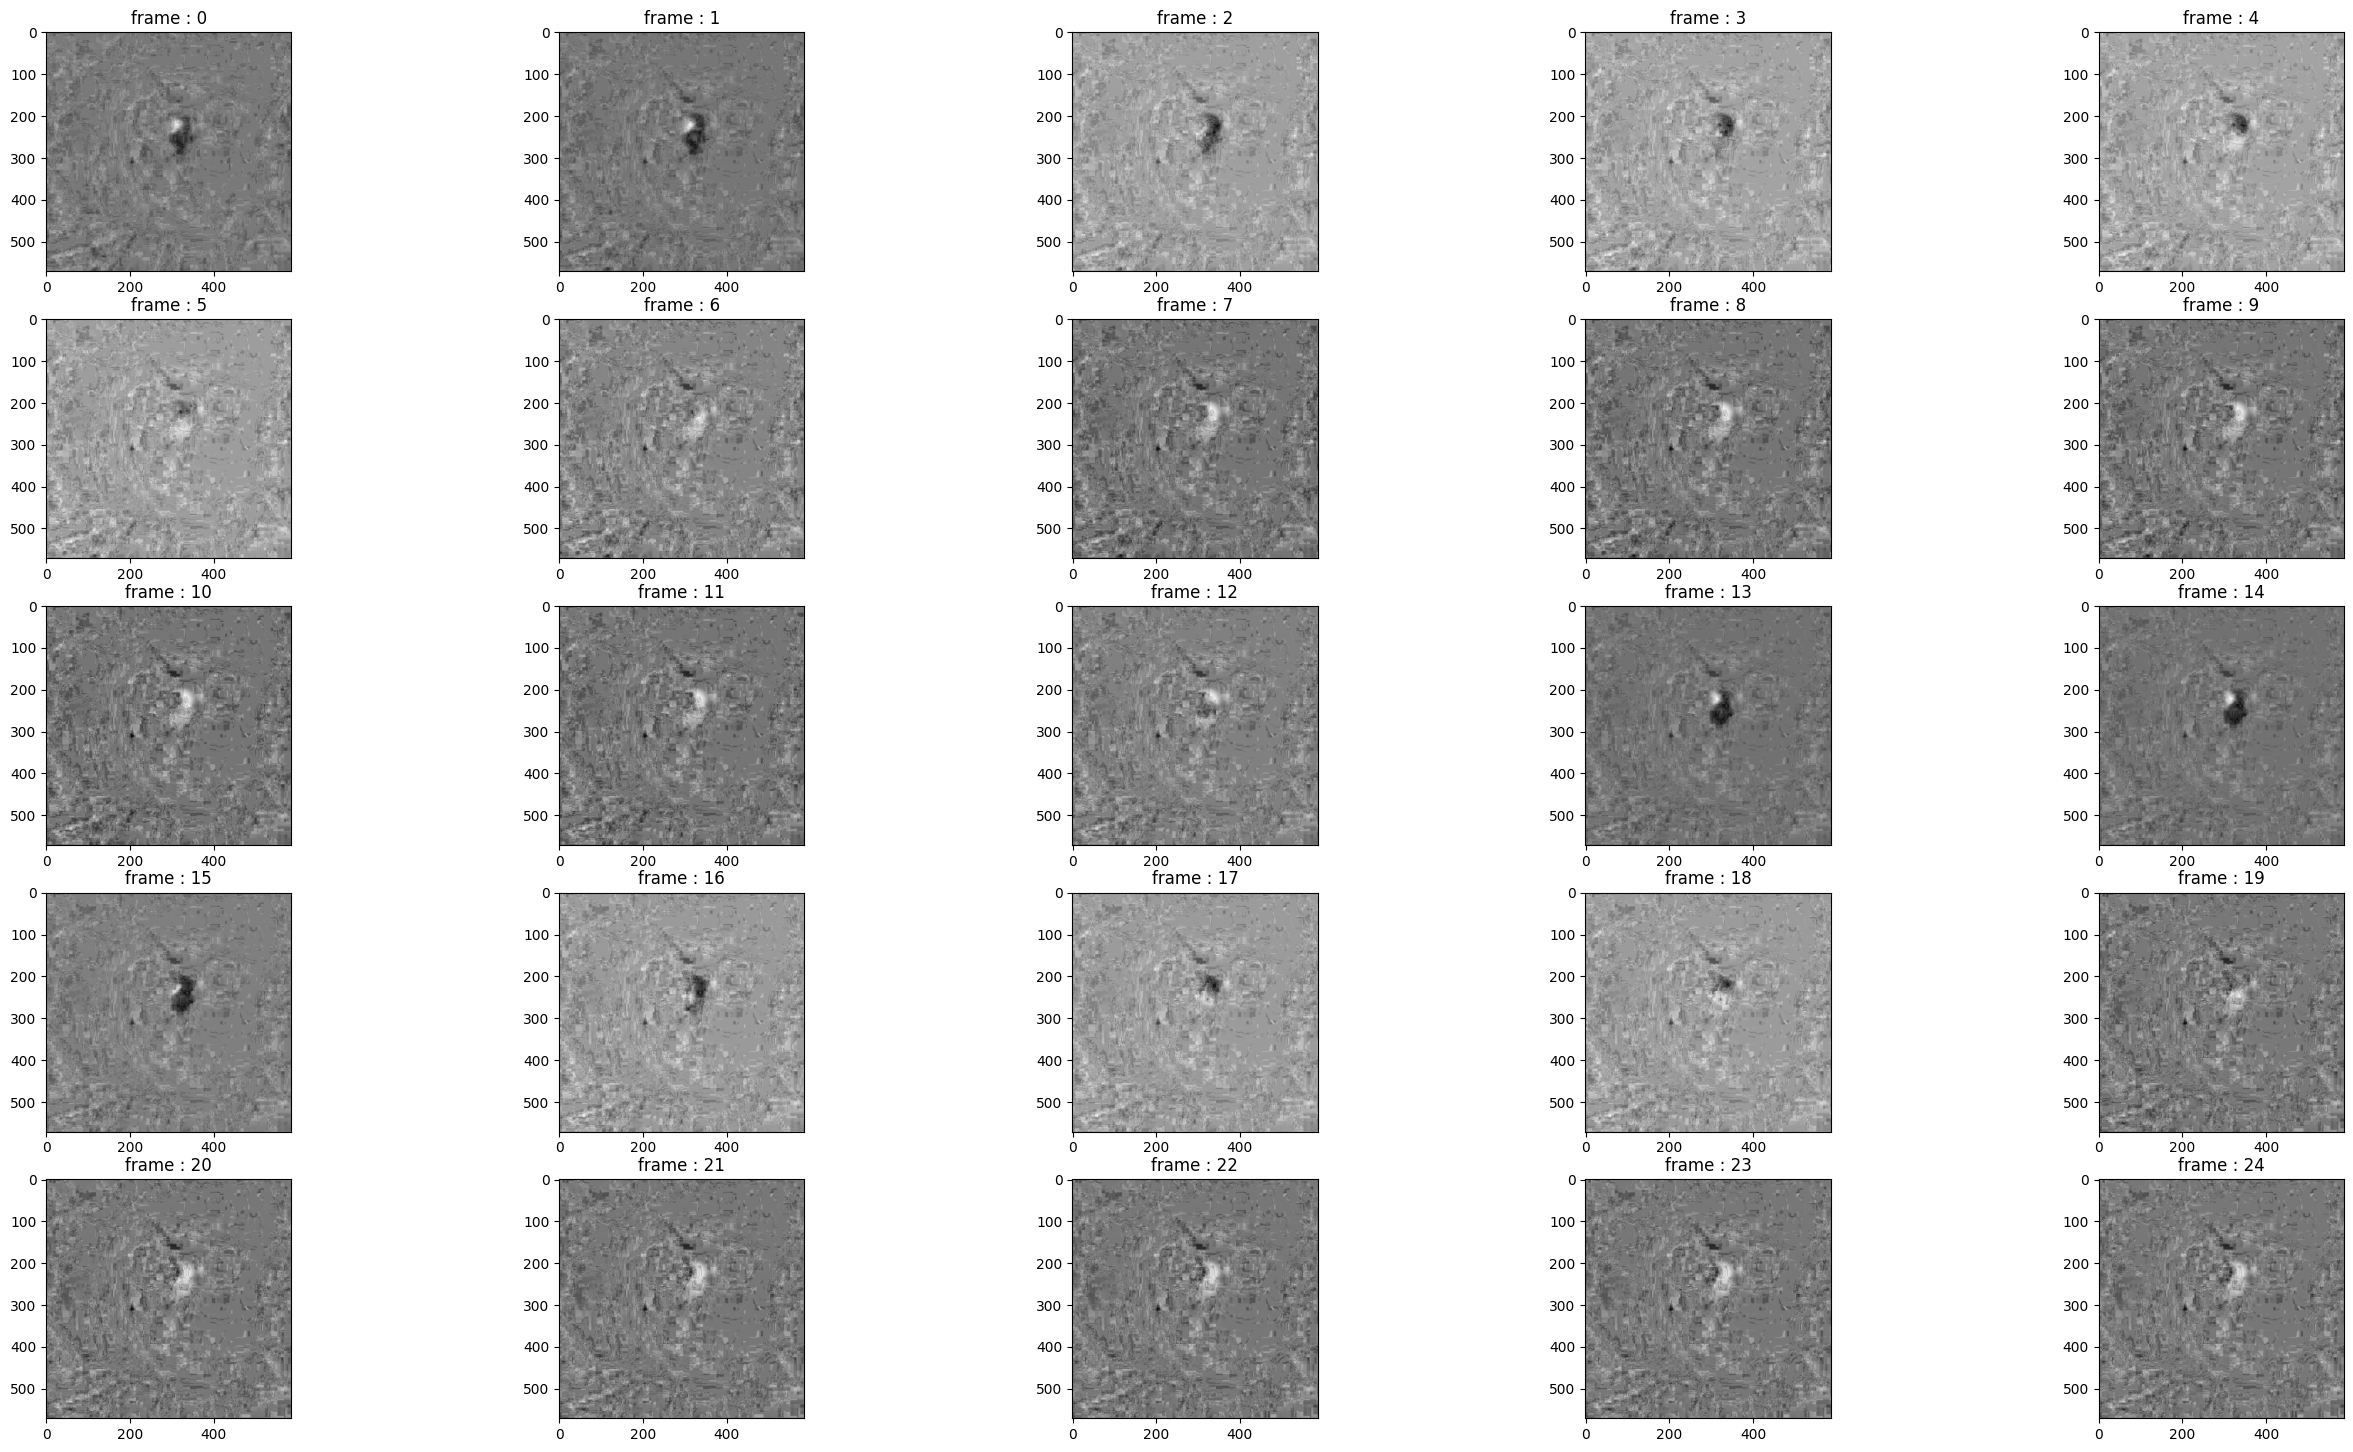

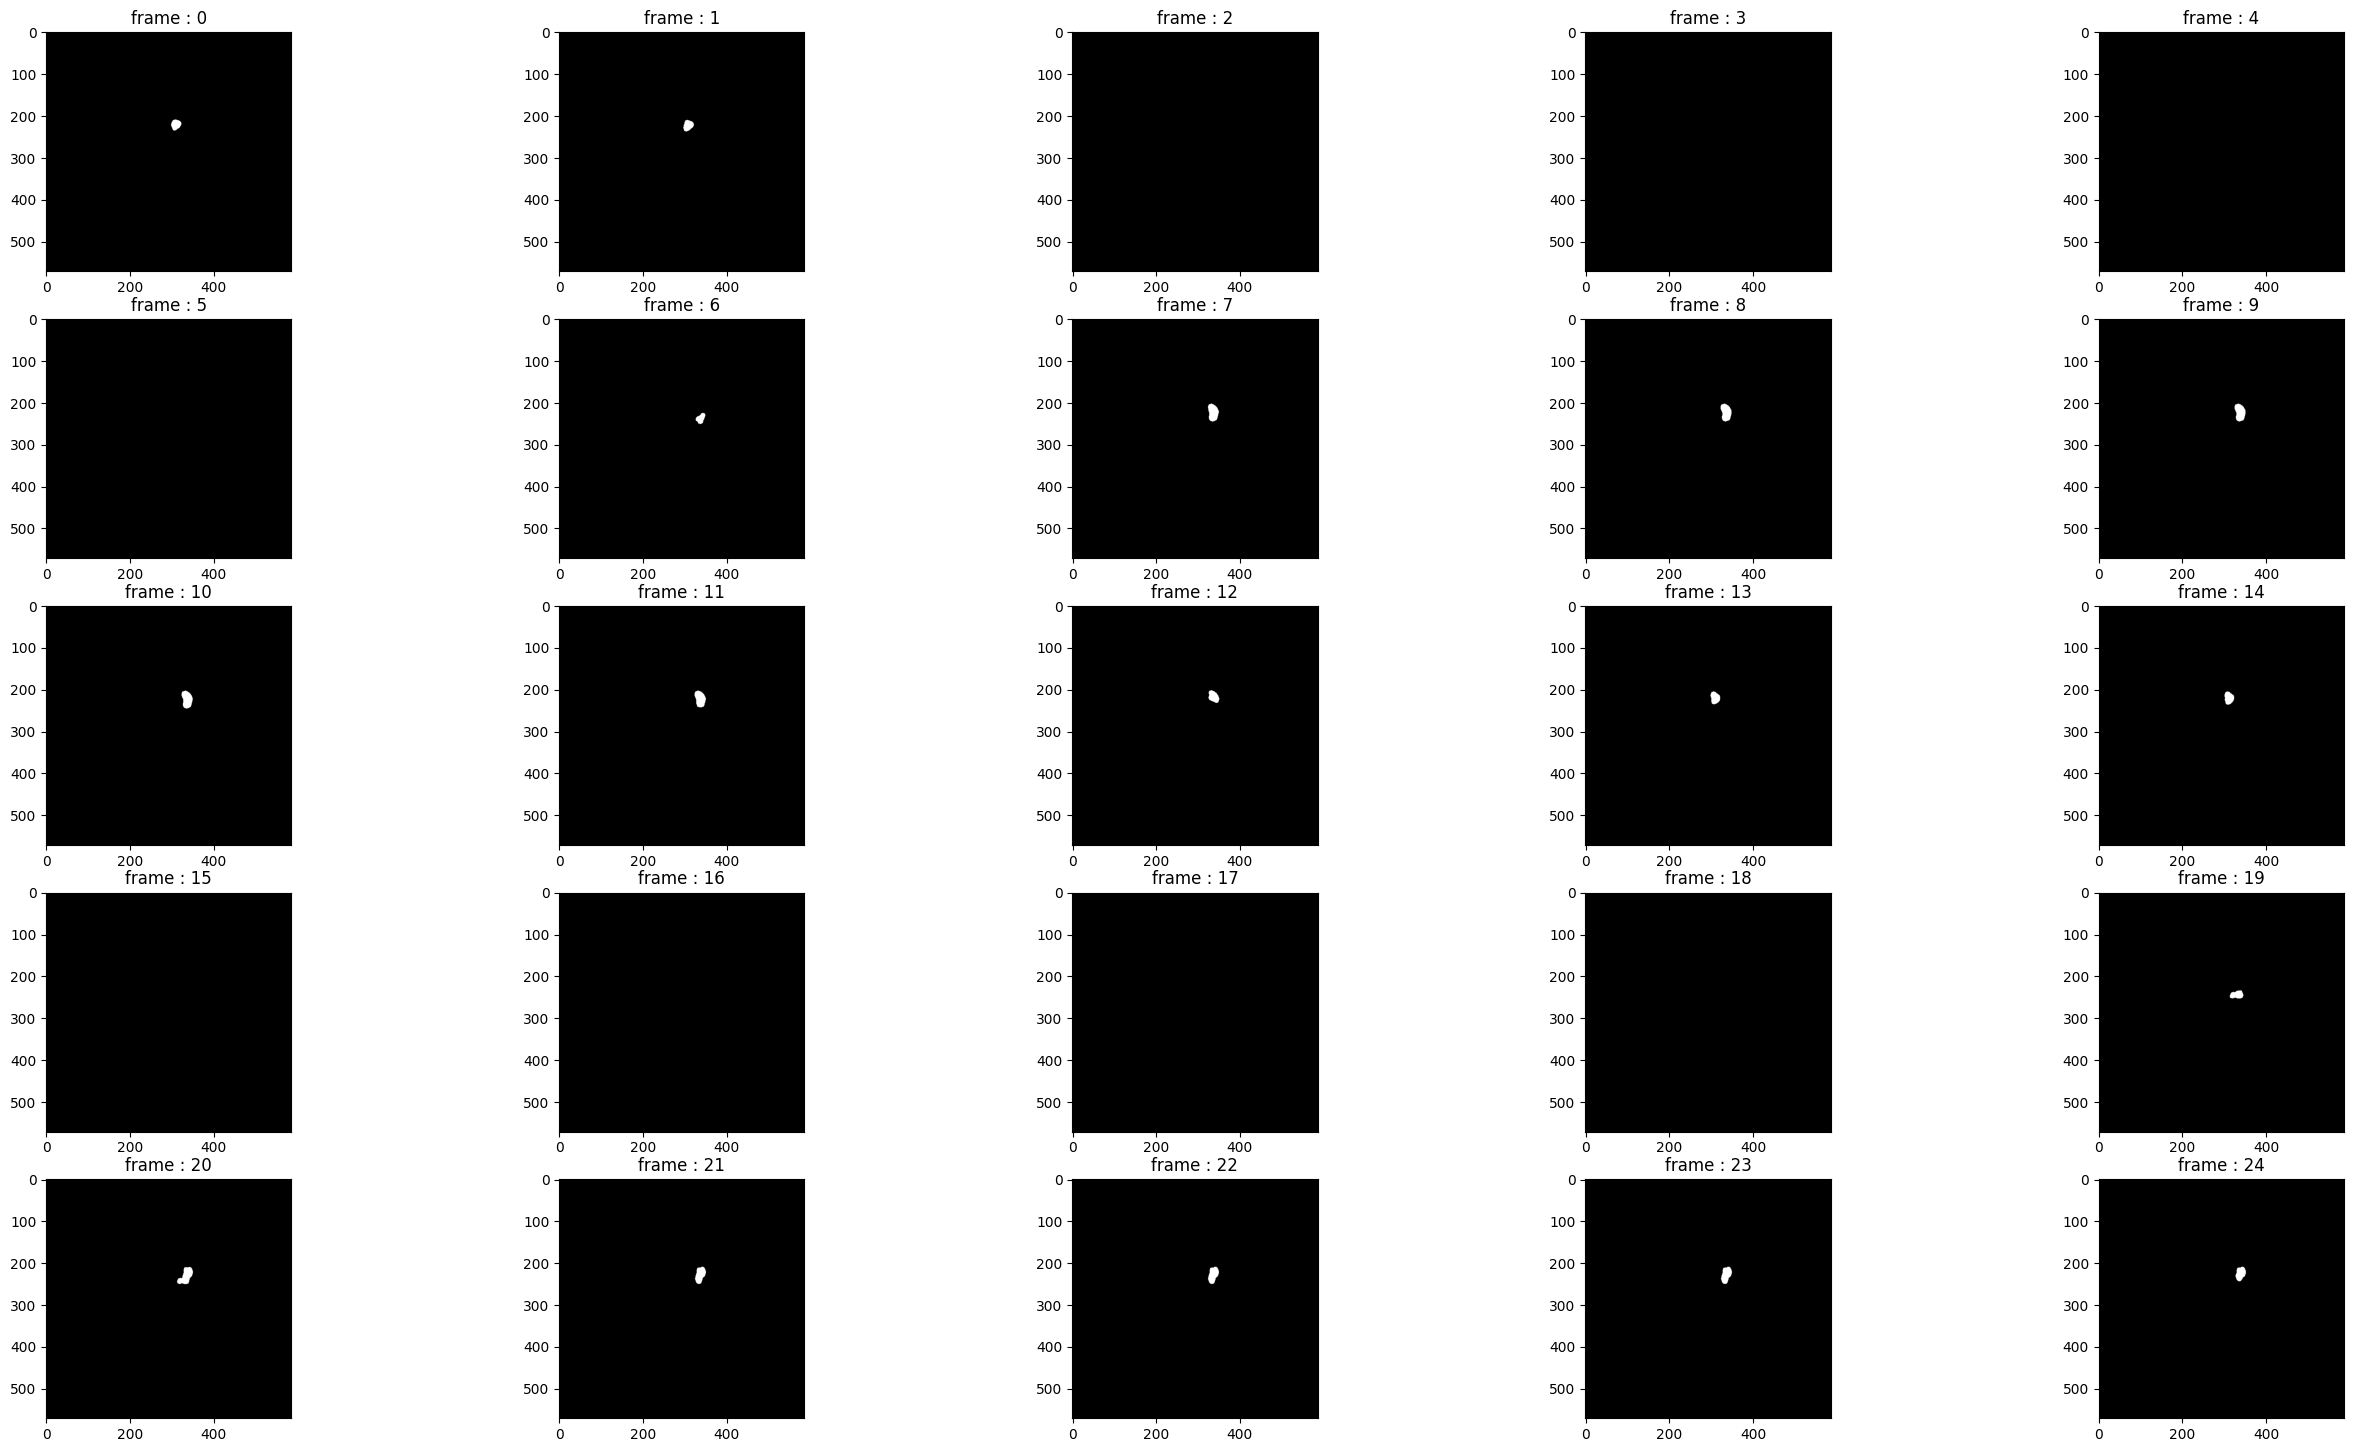

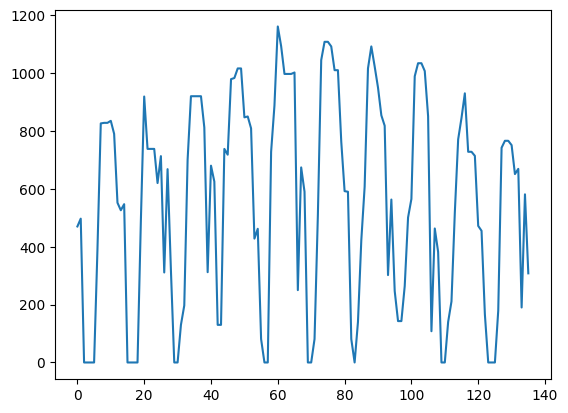

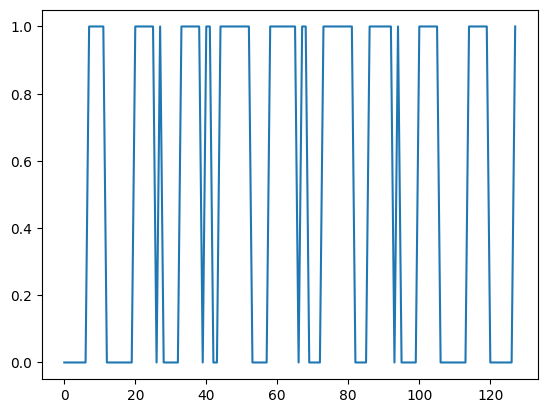

frequency for video dataset/jour_3.mp4 with numpy's fft : 126.5625
frequency for video dataset/jour_3.mp4 with our fft : 126.5625


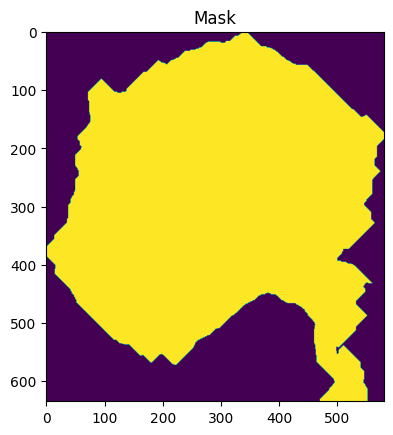

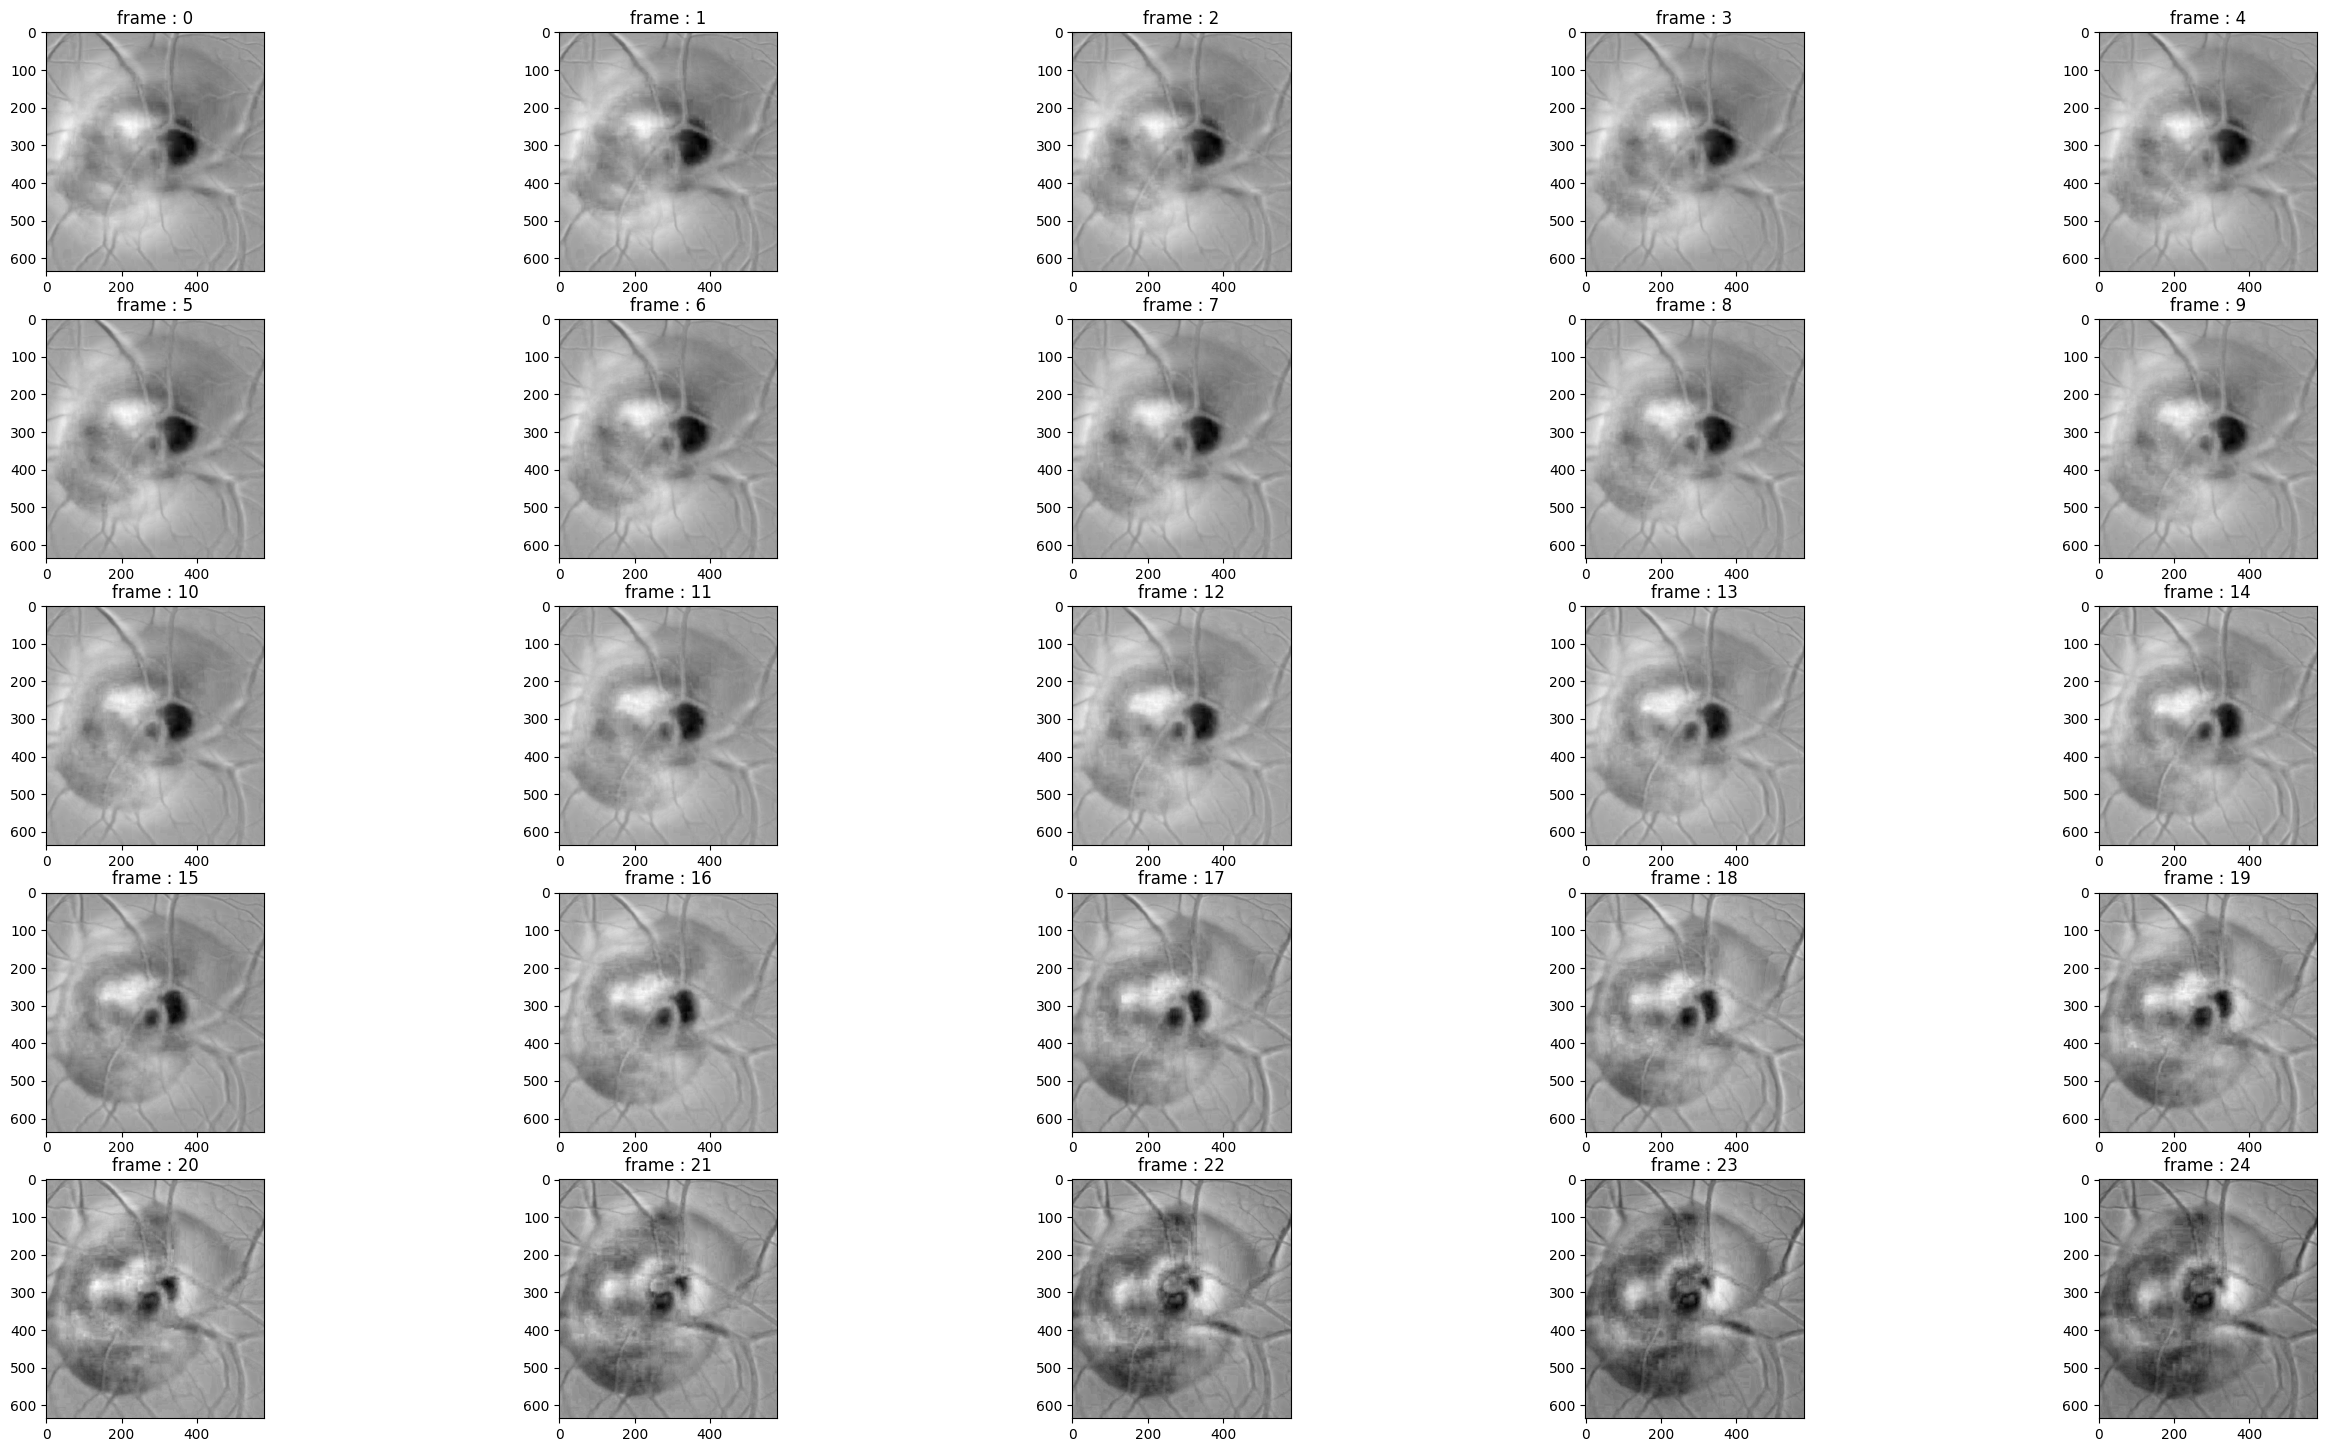

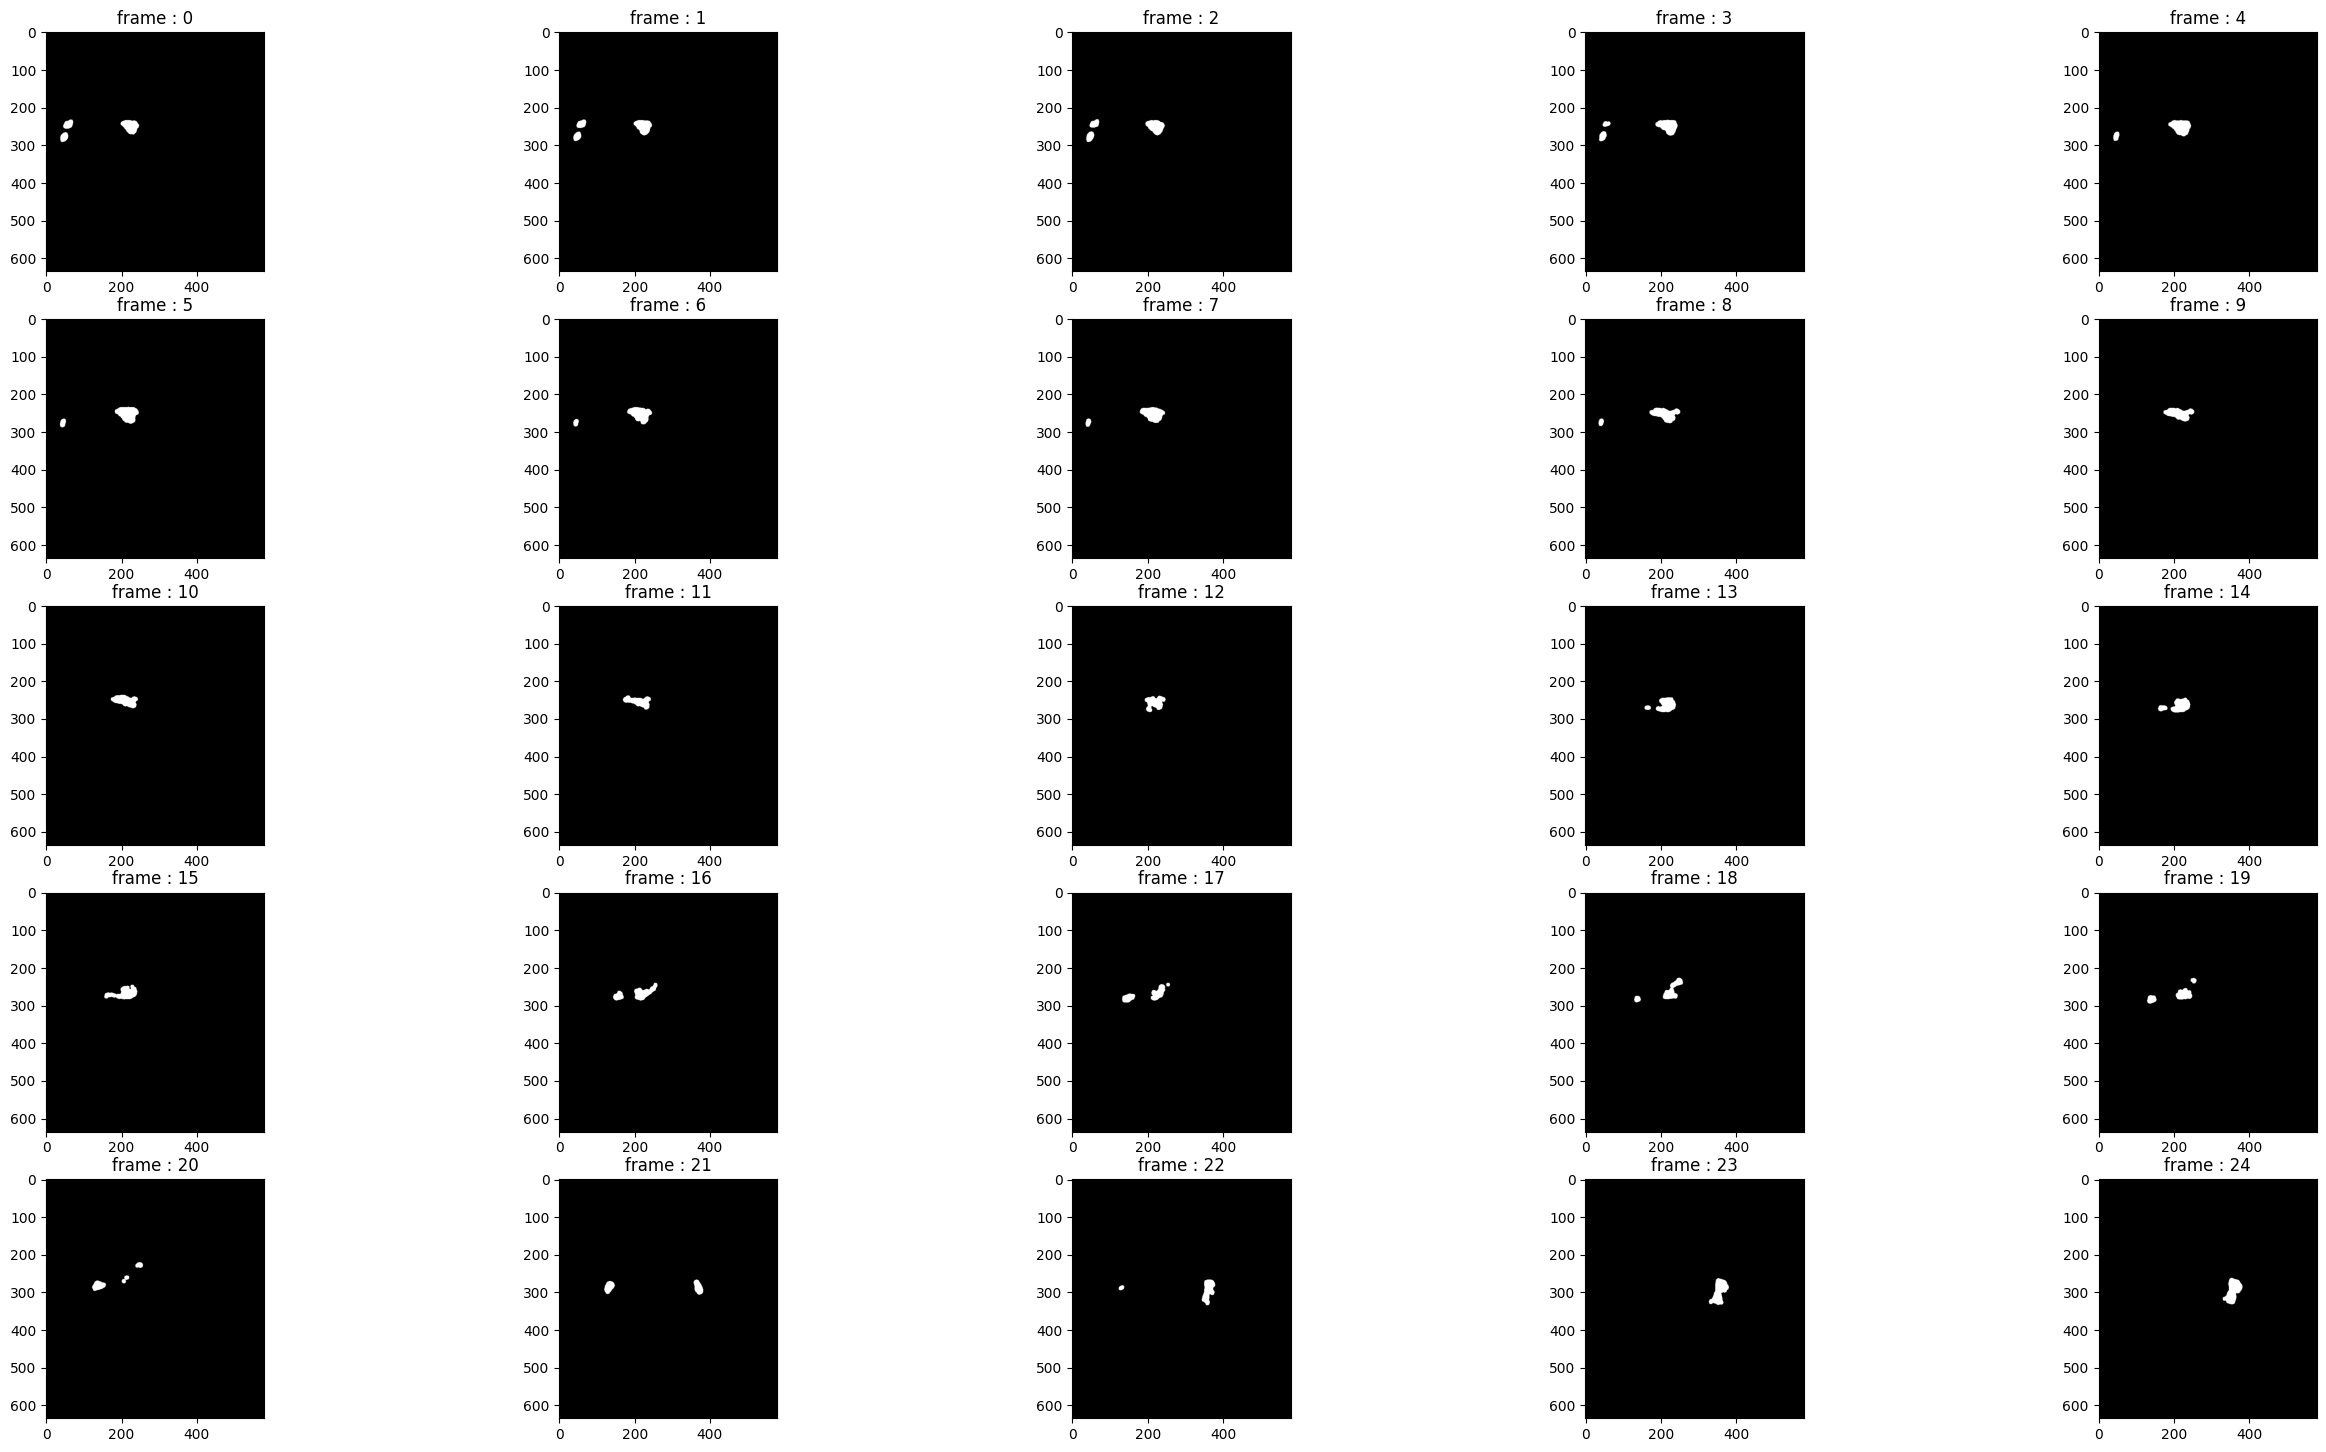

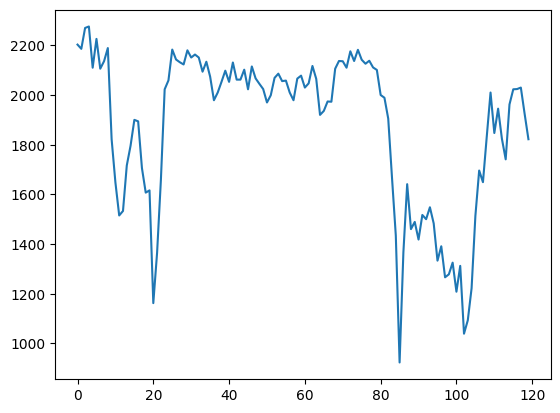

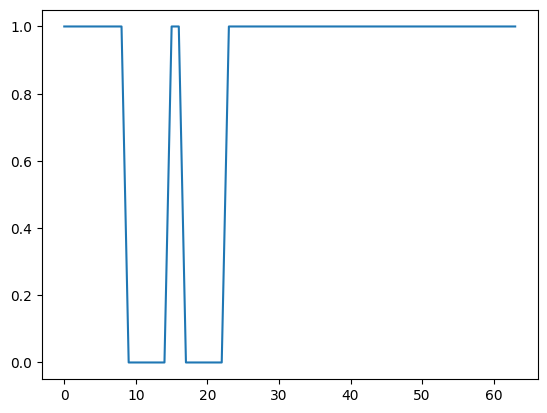

frequency for video dataset/jour_6.mp4 with numpy's fft : 0.0
frequency for video dataset/jour_6.mp4 with our fft : 0.0


In [9]:
for path in paths:  # len(paths)
    frames = load_video_as_frame(path=path.as_posix())

    mask = get_mask(frames[0])
    bounds = get_boundaries(mask)

    frames = frames[..., bounds[0]:bounds[1], bounds[2]:bounds[3]]
    mask = mask[bounds[0]:bounds[1], bounds[2]:bounds[3]]

    plt.title("Mask")
    plt.imshow(mask)
    plt.show()

    mean_frame = np.mean(frames, axis=0)

    frames = frames.astype(float)
    for i in range(frames.shape[0]):
        frames[i] -= mean_frame
        frames[i] -= frames[i].min()
        frames[i] *= 255./frames[i].max()
    frames = frames.astype(np.uint8)
    show_25_next_frames(frames, 0)

    for i in range(frames.shape[0]):
        high = np.percentile(frames[i][mask], 99)
        frames[i] = gaussian_filter(frames[i], sigma=2) > high
        frames[i] = opening(frames[i], disk(5))
    show_25_next_frames(frames, 0)

    arr = [np.sum(i) for i in frames]
    plt.plot(arr)
    plt.show()

    arr = (np.array(arr) - np.mean(arr)) > 0
    target_length = 2 ** int(np.log2(len(arr)))
    arr = arr[:target_length]
    plt.plot(arr)
    plt.show()
    print(f"frequency for video {path.as_posix()} with numpy's fft : {compute_frequency(arr, np.fft.fft)}")
    print(f"frequency for video {path.as_posix()} with our fft : {compute_frequency(arr, fft)}")